In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import qiskit
import numpy as np

from PatchedMeasCal.tensor_patch_cal import TensorPatchFitter
from PatchedMeasCal.inv_measure_methods import aim, sim
from PatchedMeasCal.jigsaw import jigsaw
from PatchedMeasCal.qiskit_meas_fitters import qiskit_full, qiskit_linear


from PatchedMeasCal.fake_backends import LocalSimulator


from PatchedMeasCal import state_prep_circuits
from PatchedMeasCal.fake_measurement_distributions import renormalise_measurement_results
from PatchedMeasCal.utils import Progressbar

from PatchedMeasCal.fake_backends import Grid, Hexagonal16, FullyConnected

from PatchedMeasCal.state_prep_circuits import GHZ_prep, GHZ_state_dist
from PatchedMeasCal.bv import bv_circuit_cmap


from qiskit import Aer, execute, QuantumCircuit
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

from functools import partial

import qiskit.tools.jupyter

import mthree

import random

qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider()

%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

## Setup
The idea here is that each approachs gets a maximum of 32000 measurement shots to spend
- Backend style methods will spend 50% of that on the build, 50% of that on the run
- Circuit style methods will spend 50% on their full run, and the other 50% on other circuits that need to be exectued
- AIM will divide theirs up evenly

In [2]:
n_qubits = 5
n_meas_shots = 16000
n_build_shots = 16000
n_shots_qiskit_full = n_build_shots // (2 ** n_qubits) 
n_shots_qiskit_partial = n_build_shots // (n_qubits)


n_circuit_method_shots = n_meas_shots + n_build_shots
backend = provider.get_backend('ibmq_lima')

n_shots_cmc = n_build_shots // (2 * len(backend.configuration().coupling_map))

err_cmap = [[1, 4], [2, 4], [3, 4], [0, 3], [0, 4]]

## Mitigation Methods Build

In [3]:
full_filter = qiskit_full(backend, n_qubits, n_shots_qiskit_full)

# n Circuits to execute
linear_filter = qiskit_linear(backend, n_qubits, n_shots_qiskit_partial)

mit = mthree.M3Mitigation(backend)
mit.cals_from_system(list(range(n_qubits)), n_build_shots // 2)

tpf_err = TensorPatchFitter(backend, n_shots=n_shots_cmc, coupling_map=err_cmap)
tpf_err.build(verbose=True)

tpf = TensorPatchFitter(backend, n_shots=n_shots_cmc)
tpf.build(verbose=True)

ERROR:websocket:error from callback <bound method BaseWebsocketClient.on_close of <qiskit.providers.ibmq.api.clients.websocket.WebsocketClient object at 0x7f410fefe160>>: on_close() missing 2 required positional arguments: 'status_code' and 'msg'
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002


Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits


ERROR:websocket:close status: 4002


	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s
Building Coupling Graph
Building Edge Calibrations
	Building Calibration Circuits
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Building Edge Patches : [====================] 100.0%  ETA: 0s
	Constructing Calibration Circuits : [====================] 100.0%  ETA: 0s
	Executing Calibration Circuits


ERROR:websocket:close status: 4002


	De-hexing Measurement Results
	Tracing Patched Calibration Results : [====================] 100.0%  ETA: 0s
Building Patch Calibrations
	Merging Patches : [====================] 100.0%  ETA: 0s
Building Measure Fitter
	Building Meas Fitters from Patches : [====================] 100.0%  ETA: 0s


## Run with repetitions
If everything above is working, let's crank it out a few times

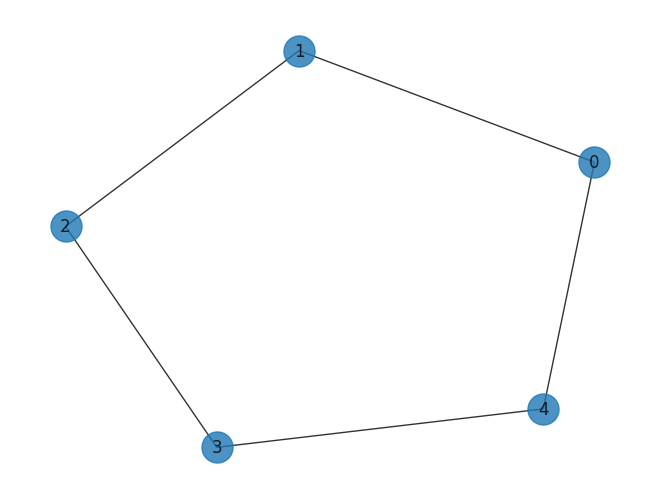

In [4]:
G = nx.Graph()
G.add_nodes_from(list(range(n_qubits)))
G.add_edges_from([(i, (i + 1) % n_qubits) for i in list(range(n_qubits))])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

Qiskit QAOA Code

In [9]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta, backend=backend):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qiskit.transpile(qc, backend=backend)

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, *args, **kwargs):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """    
    def execute_circ(theta, *args, backend=None, mitigation=None, execution=None, **kwargs):
        qc = create_qaoa_circ(G, theta, backend=backend)
        if execution is None:
            counts = backend.run(qc, *args, **kwargs).result().get_counts()
        else:
            counts = execution(qc, *args, **kwargs)
            
        if mitigation is not None:
            counts = mitigation(counts, *args, **kwargs)
        
        return compute_expectation(counts, G)
    
    return partial(execute_circ, *args, **kwargs)

In [6]:
target_val = 0
n_trials = 1000
expectation = get_expectation(G, backend=LocalSimulator(n_qubits))
for i in range(n_trials):
    target_val += expectation([1.0, 1.0])
target_val /= n_trials
print(target_val)

def distance_measure_base(x, target_val):
    return abs(x - target_val)
dist_measure = lambda x: distance_measure_base(x, target_val)

-1.783068359375


In [12]:
n_reps = 8
results = {
    'bare':[],
    'full':[],
    'linear':[],
    'aim':[],
    'sim':[],
    'jigsaw':[],
    'cmc':[],
    'cmc_err':[],
    'm3':[]
}

aim_l = lambda circ: aim(circ, backend, n_qubits, n_shots=n_circuit_method_shots, equal_shot_distribution=True)
sim_l = lambda circ: sim(circ, backend, n_qubits, n_shots=n_circuit_method_shots, equal_shot_distribution=True)
jigsaw_l = lambda circ: jigsaw(circ, backend, n_circuit_method_shots, equal_shot_distribution=True)
mit_apply = lambda x: mit.apply_correction(x, list(range(n_qubits))).nearest_probability_distribution()

for _ in range(n_reps):

    expectation = get_expectation(G, backend=backend)
    res = expectation([1.0, 1.0]) 
    results['bare'].append(
        dist_measure(res)
    )
    
    expectation = get_expectation(G, backend=backend, mitigation=full_filter.apply)
    res = expectation([1.0, 1.0]) 
    results['full'].append(
        dist_measure(res)
    )
   
    expectation = get_expectation(G, backend=backend, mitigation=linear_filter.apply)
    res = expectation([1.0, 1.0]) 
    results['linear'].append(
        dist_measure(res)
    )
    
    expectation = get_expectation(G, backend=backend, mitigation=tpf.apply)
    res = expectation([1.0, 1.0]) 
    results['cmc'].append(
        dist_measure(res)
    )
    
    expectation = get_expectation(G, backend=backend, mitigation=tpf_err.apply)
    res = expectation([1.0, 1.0]) 
    results['cmc_err'].append(
        dist_measure(res)
    )
    
    
    expectation = get_expectation(G, backend=backend, mitigation=mit_apply)
    res = expectation([1.0, 1.0]) 
    results ['m3'].append(
        dist_measure(res)
    )
                                               
    expectation = get_expectation(G, backend=backend, execution=sim_l)
    res = expectation([1.0, 1.0]) 
    results['sim'].append(
        dist_measure(res)
    )
    
    expectation = get_expectation(G, backend=backend, execution=aim_l)
    res = expectation([1.0, 1.0]) 
    results['aim'].append(
        dist_measure(res)
    )
                                               
    expectation = get_expectation(G, backend=backend, execution=jigsaw_l)
    res = expectation([1.0, 1.0]) 
    results['jigsaw'].append(
        dist_measure(res)
    )

ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:close status: 4002
ERROR:websocket:clos

In [22]:
results

{'bare': [0.23293164062499994,
  0.28643164062500004,
  0.2524316406249998,
  0.250431640625,
  0.2639316406250001],
 'full': [0.33398980572079484,
  0.2129848292016252,
  0.2038634036995035,
  0.215931658867893,
  0.23569537539797203],
 'linear': [0.20184350809001228,
  0.23810580334645604,
  0.19035809217994526,
  0.28530244960904305,
  0.2393299413314769],
 'aim': [0.46559830729166674,
  0.4094316406249998,
  0.4450149739583331,
  0.40659830729166657,
  0.47343164062499987],
 'sim': [0.40655664062499985,
  0.4056816406250001,
  0.3971191406250001,
  0.43036914062499987,
  0.45430664062500004],
 'jigsaw': [0.20420856153978217,
  0.43278062020228125,
  0.38606164902379314,
  0.12638769177358244,
  0.14353169628465912],
 'cmc': [0.18525893563596818,
  0.2010138408063058,
  0.148712110393995,
  0.1730403834792571,
  0.24312491335924769],
 'cmc_err': [0.1387581952499628,
  0.17272252045547765,
  0.0843087596464911,
  0.1142236695122596,
  0.13195813726938588],
 'm3': [0.2657195538268833,

In [23]:
qaoa_lima = {'bare': [0.23293164062499994,
  0.28643164062500004,
  0.2524316406249998,
  0.250431640625,
  0.2639316406250001],
 'full': [0.33398980572079484,
  0.2129848292016252,
  0.2038634036995035,
  0.215931658867893,
  0.23569537539797203],
 'linear': [0.20184350809001228,
  0.23810580334645604,
  0.19035809217994526,
  0.28530244960904305,
  0.2393299413314769],
 'aim': [0.46559830729166674,
  0.4094316406249998,
  0.4450149739583331,
  0.40659830729166657,
  0.47343164062499987],
 'sim': [0.40655664062499985,
  0.4056816406250001,
  0.3971191406250001,
  0.43036914062499987,
  0.45430664062500004],
 'jigsaw': [0.20420856153978217,
  0.43278062020228125,
  0.38606164902379314,
  0.12638769177358244,
  0.14353169628465912],
 'cmc': [0.18525893563596818,
  0.2010138408063058,
  0.148712110393995,
  0.1730403834792571,
  0.24312491335924769],
 'cmc_err': [0.1387581952499628,
  0.17272252045547765,
  0.0843087596464911,
  0.1142236695122596,
  0.13195813726938588],
 'm3': [0.2657195538268833,
  0.22525579642653604,
  0.23868813767940145,
  0.22618087557060473,
  0.19555934578906942]}

In [24]:
res = qaoa_lima
for r in res:
    avg = np.mean(res[r])
    h_bound = np.max(res[r]) - avg
    l_bound = avg - np.min(res[r])
    print(r, " & ", "$", "%.2f" % avg, "\substack{+", "%.2f" % h_bound, " \\\\ -", "%.2f" %l_bound, "}$", sep='')

bare & $0.26\substack{+0.03 \\ -0.02}$
full & $0.24\substack{+0.09 \\ -0.04}$
linear & $0.23\substack{+0.05 \\ -0.04}$
aim & $0.44\substack{+0.03 \\ -0.03}$
sim & $0.42\substack{+0.04 \\ -0.02}$
jigsaw & $0.26\substack{+0.17 \\ -0.13}$
cmc & $0.19\substack{+0.05 \\ -0.04}$
cmc_err & $0.13\substack{+0.04 \\ -0.04}$
m3 & $0.23\substack{+0.04 \\ -0.03}$
